Goal: combine SNAP data, which is monthly trends over 100 years, and DayMet, which is daily data over recent history, to form a reasonable cycle of data following the SNAP trend but with reasonable daily cycles.

In [ ]:
#%matplotlib

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
#import colors
import itertools

In [2]:
# short names for keys
k_T = 'air temperature [K]'
k_qSW = 'incoming shortwave radiation [W m^-2]'
k_qLW = 'incoming longwave radiation [W m^-2]'
k_Pr = 'precipitation rain [m s^-1]'
k_Ps = 'precipitation snow [m SWE s^-1]'
k_P = 'precipitation [m s^-1]'
k_RH = 'relative humidity [-]'
k_time = 'time [s]'
k_U = 'wind speed [m s^-1]'


In [3]:
def load_met(fname, adjust=-1,cycle=365,adjust_rain=-1,adjust_snow=-1):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        assert(len(_daymet[k_time][:])%cycle == 0)
        daymet_nyears = int(len(_daymet[k_time][:]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:].reshape((daymet_nyears,cycle))
    try:
        if adjust_rain >1:
            daymet[k_Pr] = adjust_rain*daymet[k_Pr]
        if adjust_snow >1:
            daymet[k_Ps] = adjust_snow*daymet[k_Ps]
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
        if (adjust>1):
            #print (adjust,daymet[k_P].mean(1))
            daymet[k_P] = adjust*daymet[k_P]
            #print ('Adjusting',adjust,daymet[k_P].mean(1))
    except KeyError:
        pass
    return daymet_nyears, daymet
  
def load_barrow_observed_met(fname, cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        end = 0
        if (len(_daymet[k_time][:])%cycle == 0):
            end = -1
        else:
            end = -(len(_daymet[k_time][:])%cycle)
        print (len(_daymet[k_time][:]),end)
        daymet_nyears = int(len(_daymet[k_time][:end]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:end].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
    except KeyError:
        pass
    return daymet_nyears, daymet

In [11]:
#nyears, daymet_FM = load_met('/Users/ajc/Core/PreProcessing/forcing_data/barrow1985-2015/barrow1985-2015-FM.h5',adjust=1.0)
#year_dm_FM = np.arange(1985, 1985+nyears)
#normalization_FM = dict()

nyears, daymet_FM = load_met('/Users/ajc/Core/PreProcessing/forcing_data/barrow1985-2015/barrow1985-2015-adjustedsmooth.h5',adjust=1.0)
year_dm_FM = np.arange(1985, 1985+nyears)
normalization_FM = dict()

nyears, daymet = load_met('/Users/ajc/Core/PreProcessing/forcing_data/Barrow_Alaska/barrow1980-2018_adjusted_smooth.h5',adjust=1.0)
#nyears, daymet = load_met('/Users/ajc/research/PreProcessing/forcing_data/Daymet/barrow1980-2018_adjusted.h5',adjust=1.0)
year_dm = np.arange(1980, 1980+nyears)
normalization = dict()

nyears, daymet_raw = load_met('/Users/ajc/Core/PreProcessing/forcing_data/Barrow_Alaska/barrow1980-2018_corrected.h5',adjust=1.)
year_dm = np.arange(1980, 1980+nyears)
normalization_dmraw = dict()

nyears_bo, barrow_observed = load_barrow_observed_met('../Barrow_Alaska/Barrow-2010_2016-updated-smooth-30pc.h5')
year_bo = np.arange(2010, 2010+nyears_bo)

#print (daymet_FM.keys())
print (daymet.keys())

2513 -323
dict_keys(['air temperature [K]', 'air temperature detrended [K]', 'incoming shortwave radiation [W m^-2]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]', 'relative humidity [-]', 'wind speed [m s^-1]', 'precipitation [m s^-1]'])


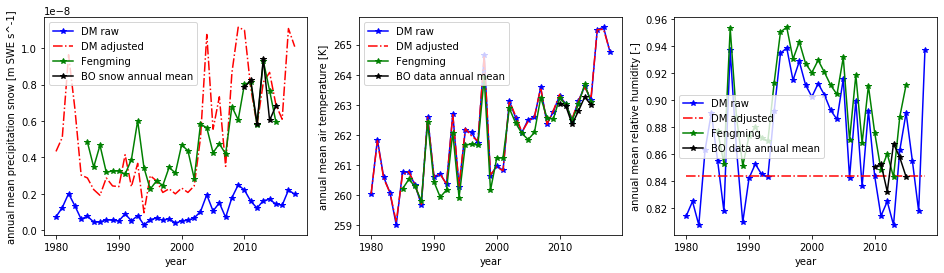

In [12]:
# check for trends in things we don't expect trends in
plt.figure(figsize=(16,4))

for i,k in enumerate([k_Ps, k_T, k_RH]):
    #print (k)
    means_DM = daymet[k].mean(1)
    means_DMraw = daymet_raw[k].mean(1)
    means_FM = daymet_FM[k].mean(1)
    plt.subplot(1,3,i+1)
    plt.plot(year_dm,means_DMraw,'b-*',label='DM raw')
    plt.plot(year_dm,means_DM,'r-.',label='DM adjusted')
    #print (daymet[k])
    plt.plot(year_dm_FM,means_FM,'g-*',label='Fengming')
    plt.ylabel('annual mean %s'%k)
    plt.xlabel('year')
    
    if i == 0:
        means_bo = barrow_observed[k_Ps].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO snow annual mean')
    if i == 1:
        means_bo = barrow_observed[k_T].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
    if i == 2:
        means_bo = barrow_observed[k_RH].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
        
    plt.legend()
    
    
plt.show()

# they look good now that wind speed has been detrended!  Look safe to use to me.
normalization[k_qSW] = daymet[k_qSW] / daymet[k_qSW].mean()
normalization[k_RH] = daymet[k_RH] - daymet[k_RH].mean()
#normalization[k_qLW] = daymet[k_qLW] / daymet[k_qLW].mean()
#ghcnd 
#snowtell 
#print (normalization[k_RH][0])

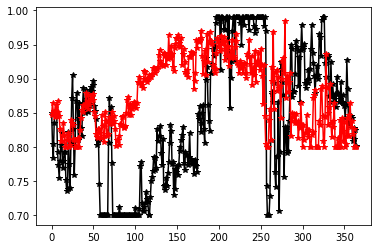

In [13]:
plt.plot(daymet[k_RH][5], 'k-*', label='BO data annual mean')
plt.plot(daymet_FM[k_RH][0], 'r-*', label='BO data annual mean')

In [ ]:
# do we need to detrend air temp?
#Plot Observed Barrow Data 
means_bo = barrow_observed[k_T].mean(1)
plt.figure(figsize=(8,5))
plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

means = daymet[k_T].mean(1)
#plt.figure()
plt.plot(year_dm,means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')


# again, do with a split at the y1th year...
# detrend the first y1 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,len(means)), means, deg=1))
plt.plot(year_dm, polyfit(np.arange(0,len(means))))


means_dtrended = means - polyfit(np.arange(0,len(means))) + means.mean()
plt.plot(year_dm, means_dtrended,'b')
#print (means - polyfit(np.arange(0,len(means))), means.mean())

plt.show()

In [ ]:
d = daymet[k_T][0] - means[0] + means_dtrended[0]
d1 = daymet[k_T][38] - means[38] + means_dtrended[38]
plt.plot(d,'g')
plt.plot(d1,'c')
#plt.plot(daymet[k_T][0],'r')
#plt.plot(daymet[k_T][38],'k')
#plt.plot(daymet['air temperature detrended [K]'][0],'k')
plt.show()

In [ ]:
# load the SNAP data
nyears_s, snap = load_met("snap-2006-2100-monthly.h5", cycle=12)
year_s = np.arange(2006, 2006+nyears_s)


In [ ]:
# also load CESM RCP4.5 just for comparison sake
nyears_c, cesm45 = load_met("../CESM/CESM_4_5.h5", cycle=365)
year_c = np.arange(2006, 2006+nyears_c)

nyears_c85, cesm85 = load_met("../CESM/CESM_8_5.h5", cycle=365,adjust=1.0,adjust_rain=1.5,adjust_snow=1.6)
plt.plot(cesm85[k_P][0])

In [ ]:
#cm = colors.cm_mapper(0,3)
cm = ['b','k','r','g','c','p']
def plot(yr, ds, k, label, i):
    plt.plot(yr, ds[k].mean(1), label=label, color=cm[i])
    poly = np.poly1d(np.polyfit(yr, ds[k].mean(1), deg=1))
    print (poly(yr[0]))
    plt.plot(yr, poly(yr), color=cm[i])
    return poly

poly_trends = dict()
for dset in ['DayMet', 'SNAP', 'CESM RCP4.5', 'CESM RCP8.5']:
    poly_trends[dset] = dict()
    
def plot_all(k):
    poly_trends['DayMet'][k] = plot(year_dm, daymet, k, 'DayMet', 0)
    #poly_trends['SNAP'][k] = plot(year_s, snap, k, 'SNAP', 1)
    #poly_trends['CESM RCP4.5'][k] = plot(year_c, cesm45, k, 'CESM RCP4.5', 2)
    poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3)
    #print (poly_trends['CESM RCP8.5'])
    #plt.plot(year_bo,means_bo, 'r-*', label='BO data annual mean')
    plt.xlabel('year')
    plt.ylabel("annual mean %s"%k)
    plt.legend()



In [ ]:
# check for trends
plt.figure(figsize=(16,10))
plt.subplot(231)
plot_all(k_qSW)
plt.subplot(232)
plot_all(k_Pr)
plt.subplot(233)
plot_all(k_Ps)
plot_all(k_P)
plt.subplot(234)
plot_all(k_T)
plt.subplot(235)
plot_all(k_RH)
plt.subplot(236)

plot_all(k_U)
plt.show()

In [ ]:
"""
def generator(data):
    for i in itertools.cycle(range(3)):
        print (i)
        yield data[i,:]
A = np.array([[1,2,3],[-1,-2,-3],[11,21,31]])
for i in range(3):
    x = list(generator(A))
    print (i,x)
"""

In [ ]:
# utilities
def year_generator(dat):
    print ('Shape: ',dat.shape[0])
    for i in itertools.cycle(range(dat.shape[0])):
        #print (i,dat.shape[0])
        yield dat[i,:]
       
    
def plot(years, precip_proj, trend_poly, k):
    plt.figure(figsize=(16,7))
    plt.plot(np.arange(years[0], years[-1]+1, 1.0/365), precip_proj.ravel())
    plt.plot(np.arange(year_dm[0], year_dm[-1]+1, 1.0/365), daymet[k].ravel())

    plt.plot(year_dm, poly_trends['DayMet'][k](year_dm))
    plt.plot(year_dm, daymet[k].mean(1))
    plt.plot(years, trend_poly(years))
    plt.plot(years, precip_proj.mean(1))
    plt.xlabel('year')
    plt.ylabel(k)
    plt.show()   
    
def project_and_plot(years, trend_poly, normalized, k, operator='additive'):
    print("Projecting: %s"%k)
    if operator == 'additive':
        print (operator)
        precip_proj = np.array([pr + trend_poly(yr) - pr.mean() for yr, pr in zip(years, year_generator(normalized))])
        
    elif operator == 'multiplicative':
        precip_proj = np.array([pr*trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    elif (operator == 'none'):
        precip_proj = np.array([pr for yr, pr in zip(years, year_generator(normalized))])
    else:
        raise RuntimeError('invalid operator, must be "additive" or "multiplicative"')
    
    if 'humidity' in k:
        precip_proj = np.clip(precip_proj,0.7,1.)
            
    if 'shortwave' in k:
        precip_proj = np.clip(precip_proj,0.0,1000.)
    if 'precipitation' in k:
        precip_proj = np.clip(precip_proj,0.0,1000.)
        print (precip_proj)
    plot(years, precip_proj, trend_poly, k)
    print (precip_proj.shape)
    # check min/max are reasonable
    print(precip_proj.min(), precip_proj.max())
    return precip_proj  


In [ ]:
# projected dataset
proj = dict()


In [ ]:
# use snap precip
#proj[k_P] = project_and_plot(year_s, poly_trends['SNAP'][k_P], normalization[k_P], k_P, operator="multiplicative")

In [ ]:
# use CESM RCP8.5 air temperatures, RH, and incoming SW
normalized = daymet['air temperature detrended [K]']

proj[k_T] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_T], normalized, k_T, operator='additive')
print (proj[k_T].shape)
normalized = daymet[k_RH]
proj[k_RH] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_RH], normalized, k_RH, operator='additive')

normalized = daymet[k_qSW]
proj[k_qSW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qSW], normalized, k_qSW, operator='additive')

normalized = daymet[k_U]
#print (daymet[k_U])
proj[k_U] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_U], normalized, k_U, operator='additive')

normalized = daymet[k_qLW]
proj[k_qLW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qLW], normalization[k_qLW], k_qLW, operator='additive')

normalized = daymet[k_P]
proj[k_P] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_P], normalized, k_P, operator='additive')

#print (proj[k_P])
# uh oh, need to filter RH

In [ ]:

print (proj.keys())

In [ ]:
"""
# just cycle wind speed
proj[k_U] = np.array([d for i,d in zip(range(len(year_c)), year_generator(daymet[k_U]))])
plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_U].ravel())

print(daymet[k_U].min(), daymet[k_U].max())
print(proj[k_U].min(), proj[k_U].max())
"""

In [ ]:
# partition rain
#precip = proj.pop(k_P)

#proj[k_Ps] = np.where(proj[k_T] > 273.15, 0., precip)
#proj[k_Pr] = np.where(proj[k_T] > 273.15, precip, 0)

proj[k_Ps] = np.where(proj[k_T] >= 273.15, 0., proj[k_P])
proj[k_Pr] = np.where(proj[k_T] > 273.15, proj[k_P], 0)

plt.figure(figsize=(16,7))
#plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Ps].ravel(), 'c')
#plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Pr].ravel(), 'b')


snow = np.reshape(proj[k_Ps],(-1,365)).mean(1)*1000*86400*365
rain = np.reshape(proj[k_Pr],(-1,365)).mean(1)*1000*86400*365
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), snow, 'c')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), rain, 'b')
plt.show()

In [ ]:
# save to file
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
assert(len(times) == 365*95)

#Used smooth historical data
with h5py.File("CESM-RCP8.5-2006-2100_dm1980-2018.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        print (k)
        fout.create_dataset(k, data=proj[k].ravel())

    